# **대표적인 중립금리 추정 모형의 데이터 정합성 검증**
**개요**

**I. 데이터 입수 및 전처리**

**II. 정합성 검증(인플레이션, GDP 전망)**

**III. 충격반응함수**

#### 라이브러리 호출

In [1]:
# 라이브러리 불러오기
import os
from bok_da.valid.nir import NIRValidation, Spec, ModelPaths, print_rmse_mae, print_mda
import pandas as pd

# 시각화
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.tsa.api as VAR
import statsmodels.formula.api as smf

# 데이터프레임 숫자출력 옵션
pd.set_option('display.precision', 2)

### **개요**
- 대표적인 중립금리 추정 모형의 데이터 정합성을 검증

### **I. 데이터 입수 및 전처리**
- **rgdp**: 실질GDP(계절조정, 분기), **inf1**: 근원물가(석유류, 농산물 제외), **inf2**: 근원물가(에너지, 식품류 제외), **infe**: 기대인플레이션율(향후 1년), **interest**: 무담보콜금리(1일), **ngdp**: 명목GDP(계절조정, 분기), **credit**: 가계신용, **csi**: Covid-19 Stringency Index, **ci**: Covid-19 indicator

In [2]:
# 거시경제지표 데이터 불러오기
df_all = pd.read_excel('data/nir_data_all.xlsx')
df_all.set_index('Date', inplace=True)
df_all = df_all.resample('Q').mean()
df_all

,rgdp,inf1,inf2,infe,interest,ngdp,credit,csi,ci
Date,,,,,,,,,
1960-03-31,7530.1,NaN,NaN,NaN,NaN,56.64,NaN,0.0,0.0
1960-06-30,7878.4,NaN,NaN,NaN,NaN,61.53,NaN,0.0,0.0
1960-09-30,7788.8,NaN,NaN,NaN,NaN,65.44,NaN,0.0,0.0
1960-12-31,7834.3,NaN,NaN,NaN,NaN,67.13,NaN,0.0,0.0
1961-03-31,8081.8,NaN,NaN,NaN,NaN,72.93,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2023-12-31,565597.6,111.30,109.47,3.33,3.58,613826.20,1.89e+06,0.0,0.0
2024-03-31,572951.0,111.90,110.26,3.07,3.51,632142.20,1.88e+06,0.0,0.0
2024-06-30,571646.7,112.39,110.84,3.10,3.53,638253.40,1.90e+06,0.0,0.0


In [3]:
# 중립금리 추정 모형 이름과 칼럼이름을 딕셔너리로 정의
files = {
    'Rstar_LM.csv': 'LM',
    'Rstar_FS.csv': 'FS',
    'Rstar_HLW.csv': 'HLW',
    'Rstar_HLW_FC.csv': 'HLW_FC',
    'Rstar_HLW_Covid.csv': 'HLW_Covid',
    'Rstar_HLW_smoothed.csv': 'HLW_smoothed',
    'Rstar_HLW_FC_smoothed.csv': 'HLW_FC_smoothed',
    'Rstar_HLW_Covid_smoothed.csv': 'HLW_Covid_smoothed'

}

# 빈 데이터프레임 생성
rstar = pd.DataFrame()

for file, col in files.items():
    df = pd.read_csv(f'data/{file}', index_col=0)
    df = df.iloc[:, 0]                              
    df.index = pd.to_datetime(df.index)
    df = df.resample('Q').mean()
    #df.columns = [col]
    rstar = pd.concat([rstar, df], axis=1)

rstar.columns = files.values()
rstar.index = pd.to_datetime(rstar.index)
rstar['ENS'] = rstar.mean(axis=1)
rstar['2004':]

,LM,FS,HLW,HLW_FC,HLW_Covid,HLW_smoothed,HLW_FC_smoothed,HLW_Covid_smoothed,ENS
2004-03-31,1.04,0.90,2.26,NaN,2.43,1.66,NaN,2.45,1.79
2004-06-30,1.06,0.90,2.17,NaN,2.33,1.65,NaN,2.37,1.75
2004-09-30,0.85,0.90,2.11,NaN,2.24,1.70,NaN,2.30,1.68
2004-12-31,0.58,0.86,2.05,3.28,2.20,1.73,3.17,2.23,2.01
2005-03-31,0.59,0.81,2.01,3.24,2.17,1.71,3.09,2.21,1.98
...,...,...,...,...,...,...,...,...,...
2023-09-30,0.94,-0.60,-1.06,-1.22,-1.70,0.43,-1.28,-0.87,-0.67
2023-12-31,0.96,-0.62,-1.08,-1.05,-1.69,0.46,-1.16,-0.90,-0.63
2024-03-31,0.85,-0.62,-1.09,-0.89,-1.72,0.44,-1.03,-0.92,-0.62
2024-06-30,0.71,-0.59,-1.11,-0.81,-1.73,0.42,-0.97,-0.94,-0.63


### 시각화: 모형별 중립금리 추세

In [4]:
model_list = ['LM', 'FS', 'HLW', 'HLW_FC', 'HLW_Covid', 'HLW_smoothed', 'HLW_FC_smoothed', 'HLW_Covid_smoothed', 'ENS', 'Real Call Rate']

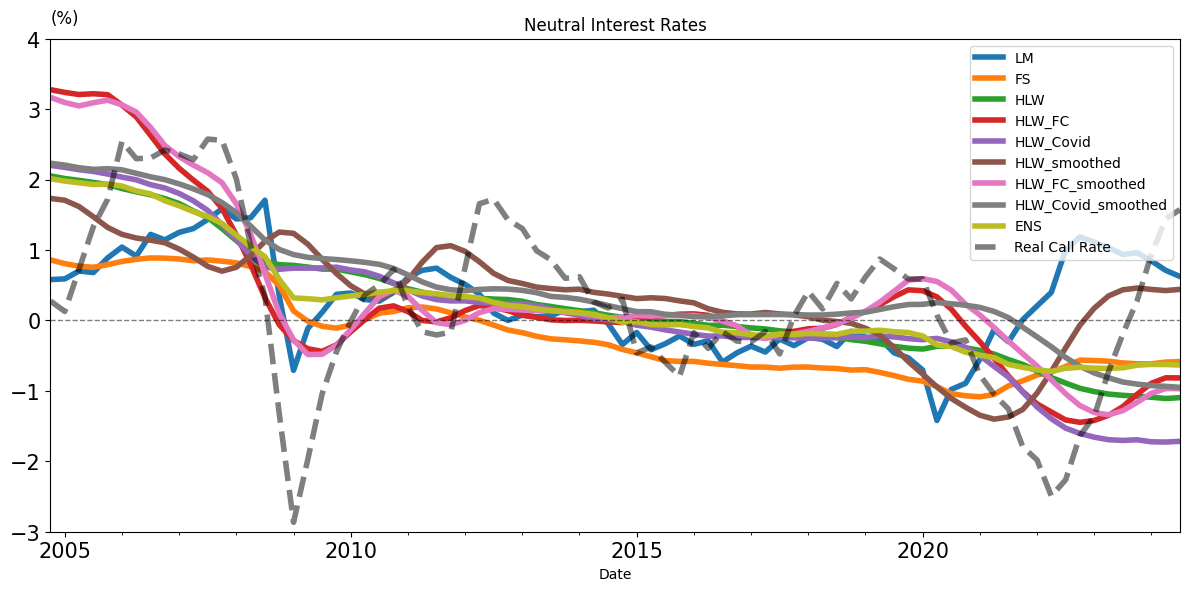

In [5]:
# 중립금리 그리기
fig, axes = plt.subplots(1, 1, figsize=(12, 6))

rstar.dropna().plot(ax=axes, title='Neutral Interest Rates', linewidth=4, fontsize=15)
(df_all.loc['2000':, 'interest'] - df_all.loc['2000':, 'inf1'].pct_change(4)*100).loc['2004-12-31':'2024-09-30'].plot(ax=axes, color='black', linestyle='--', linewidth=4, alpha=0.5)

axes.annotate('(%)', xy=(0, 1.06), xycoords='axes fraction', fontsize=12, verticalalignment='top')
y_min = -3
y_max = 4

axes.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes.set_ylim(y_min, y_max)
axes.legend(model_list, loc='upper right')
    
plt.tight_layout()
plt.show()
fig.savefig('fig/neutral_interest_rates.png', dpi=300, bbox_inches='tight')

In [6]:
# Compute the series for the actual call rate (adjusted by inflation change)
realcall = (df_all.loc['2000':, 'interest'] - df_all.loc['2000':, 'inf1'].pct_change(4)*100).loc['2004-12-31':'2024-09-30']

# Combine rstar (after dropping missing values) with the computed series.
rstar_realcall = pd.concat([rstar.dropna(), realcall.rename('Real_Call_Rate')], axis=1)

# Save the combined dataframe to a CSV file.
rstar_realcall.to_csv('rstar_realcall.csv')

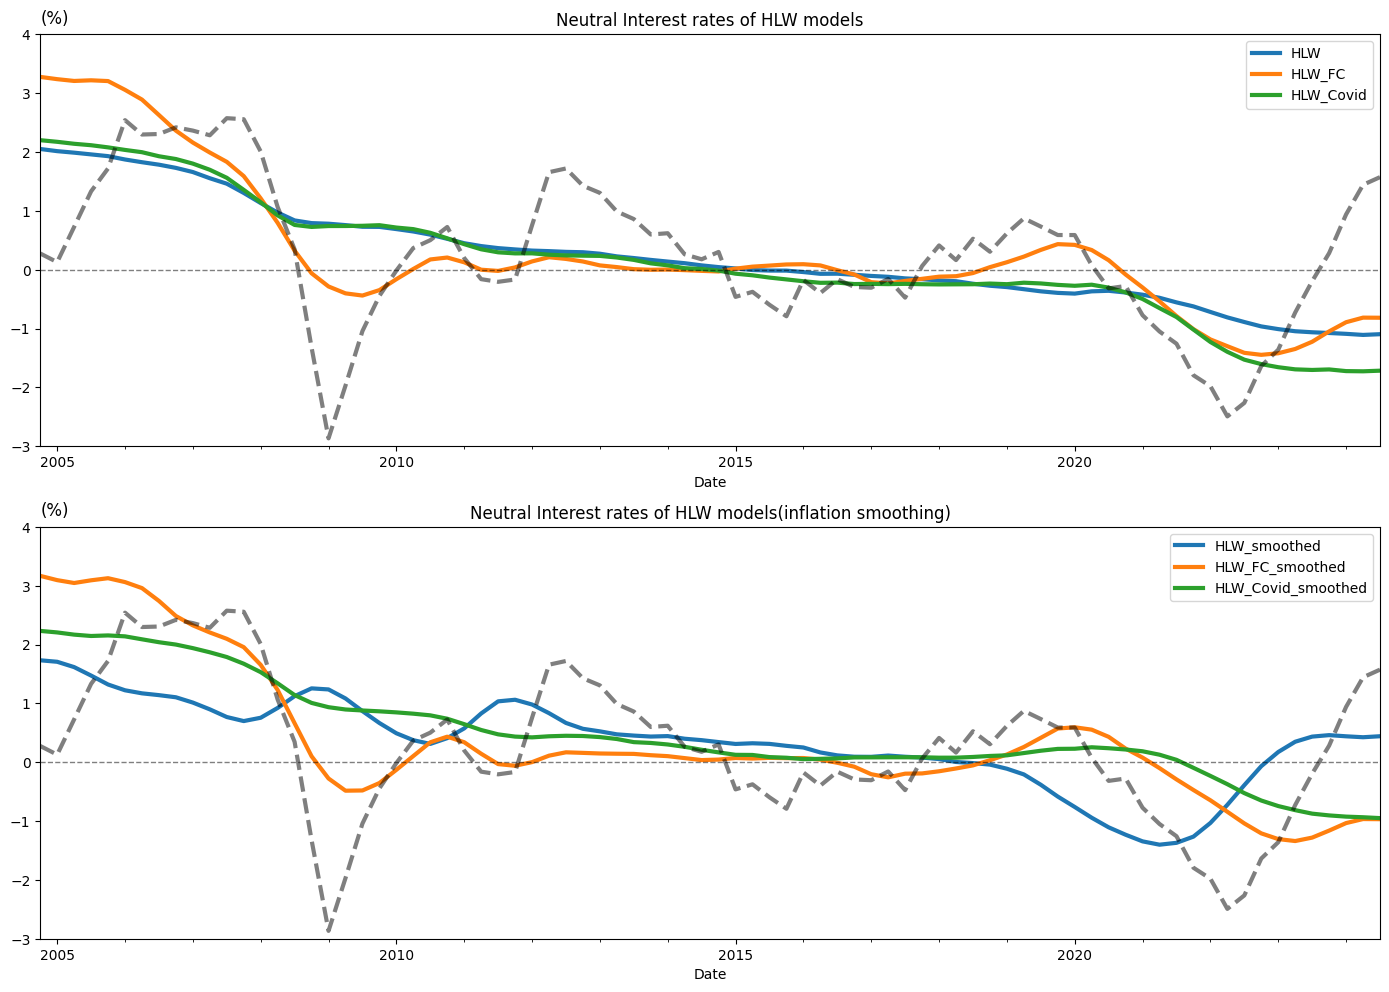

In [7]:
# HLW 모형의 중립금리와 실제 중립금리 비교
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

models = [['HLW', 'HLW_FC', 'HLW_Covid'], ['HLW_smoothed', 'HLW_FC_smoothed', 'HLW_Covid_smoothed']]
titles = ['Neutral Interest rates of HLW models', 'Neutral Interest rates of HLW models(inflation smoothing)']

for i, model_list in enumerate(models):
    rstar[model_list].dropna().plot(ax=axes[i], title=titles[i], linewidth=3)
    (df_all.loc['2000':, 'interest'] - df_all.loc['2000':, 'inf1'].pct_change(4)*100).loc['2004-12-31':'2024-09-30'].plot(ax=axes[i], color='black', linestyle='--', linewidth=3, alpha=0.5)
    axes[i].annotate('(%)', xy=(0, 1.06), xycoords='axes fraction', fontsize=12, verticalalignment='top')
    axes[i].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[i].set_ylim(y_min, y_max)
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.show()


### **II. 데이터 정합성 검증**

In [8]:
# 모형 추정 위한 경로 지정
paths = ModelPaths(
    lm_r_path= r"C:\Program Files\R\R-4.5.0\bin\Rscript.exe",
    lm_r_scr_path= fr"{os.getcwd()}\LM_R\LM_main_KOR_v2_for_py.R",
    fs_matlab_path= r"C:\Program Files\MATLAB\R2024b\bin\matlab.exe",
    fs_matlab_scr_path= fr"{os.getcwd()}\FS_matlab\Main",
    fs_matlab_lib_path= fr"{os.getcwd()}\FS_matlab\Neutral_Rate_Lib",
    hlw_nb_path = fr"{os.getcwd()}\HLW_py\HLW.ipynb",
    hlw_output_path = fr"{os.getcwd()}\HLW_py\HLW_output.ipynb",
    hlw_fc_nb_path = fr"{os.getcwd()}\HLW_py\HLW_FC.ipynb",
    hlw_fc_output_path = fr"{os.getcwd()}\HLW_py\HLW_FC_output.ipynb",
    hlw_covid_nb_path = fr"{os.getcwd()}\HLW_py\HLW_Covid.ipynb",
    hlw_covid_output_path = fr"{os.getcwd()}\HLW_py\HLW_Covid_output.ipynb"
)

#### **II-1. 물가 예측: 누적 근원물가상승률의 연율**

- 데이터셋 설정

In [9]:
df_all['rgdpg'] = df_all['rgdp'].pct_change(4) * 100
df_all['inf1g'] = df_all['inf1'].pct_change(4) * 100
df_all['realrate'] = df_all['interest'] - df_all['inf1g']

In [10]:
df = df_all.copy()
var_list = ['inf1', 'infe', 'rgdp', 'realrate']
df['rgdp'] = df['rgdp'].pct_change(4) * 100
data = df[var_list].dropna()
data_inf = data.copy()
data_inf

,inf1,infe,rgdp,realrate
Date,,,,
2002-03-31,67.60,4.35,7.27,1.01
2002-06-30,68.28,4.30,7.69,1.22
2002-09-30,68.52,3.90,8.31,1.41
2002-12-31,68.96,4.10,7.70,1.27
2003-03-31,69.75,4.47,4.21,1.08
...,...,...,...,...
2023-12-31,111.30,3.33,2.22,0.28
2024-03-31,111.90,3.07,3.09,0.94
2024-06-30,112.39,3.10,2.29,1.44


### **Walk-forward validation**
- 2010년 1분기 부터 2024년 3분기까지 rolling 방식으로 예측하고 RMSE, MAE 계산

In [11]:
# 예측 설정, Spec 객체 생성
spec = Spec(horizon=[6, 12, 24],
            targets=pd.date_range(start='2016-03-31', end='2024-09-30', freq='Q'),
            model_list=['LM', 'FS', 'HLW', 'HLW_FC', 'HLW_Covid', 
                        'HLW_smoothed', 'HLW_FC_smoothed', 'HLW_Covid_smoothed', 'RW', 'AR'],
            #model_list=['HLW_smoothed'],
            lag=1,
            rolling=10)

# spec에 paths 추가
spec.paths = paths

In [12]:
valid = NIRValidation(spec)
res = valid.nir_wfvalid_for_annualized(data_inf, target_var='inf', type='regression', mp_stance=False)

========Validation Options========
Horizon: (6, 12, 24)-months ahead
Targets Range: 2016-03-31 to 2024-09-30
Model List: ['LM', 'FS', 'HLW', 'HLW_FC', 'HLW_Covid', 'HLW_smoothed', 'HLW_FC_smoothed', 'HLW_Covid_smoothed', 'RW', 'AR']
Lag: 1
Rolling: 10-years
Target Variable: inf1
Validation type: Forecasting inf based on regression model


Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

### **RMSE, MAE**

In [13]:
# rmse, mae 테이블
rmse_mae_res, rmse_mae_avg = res.get_rmse_mae()
print_rmse_mae(rmse_mae_res, rmse_mae_avg, layout='top_bottom')

> Initiating Hangul font setup for Graphs...
> Font set to 'Malgun Gothic' and unicode_minus=False.


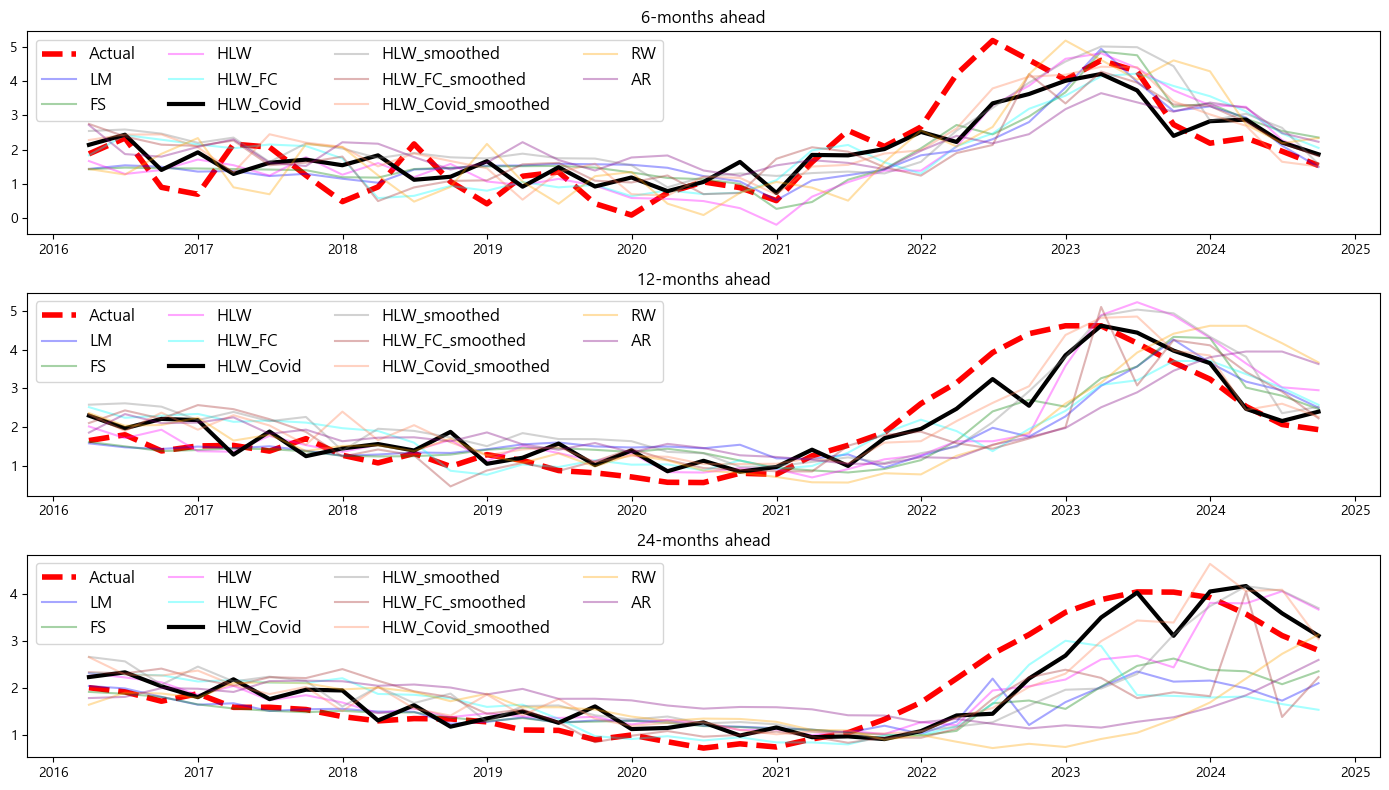

In [15]:
# 예측결과 그림
import bok_da.viz as bdz
bdz.setup_hangul_font()
# Find the model with the smallest RMSE value
min_rmse_model = rmse_mae_avg.data.loc[:, 'MAE'].idxmin()

# Update alpha values
alpha = {model: 1 if model == min_rmse_model else 0.35 for model in spec.model_list}
line_width = {model: 3 if model == min_rmse_model else 1.5 for model in spec.model_list}
res.plot_pred_results(fig_size=(14, 8), alpha=alpha, line_width=line_width, loc='upper left', n_col=4)

### **MDA**

In [17]:
# 전체기간
segments = {'full': (spec.targets[0], spec.targets[-1])}

mda_res, mda_avg = res.get_mda_seg(base='act', verbose=False, segments=segments)
print_mda(mda_res, mda_avg, layout='top_bottom')

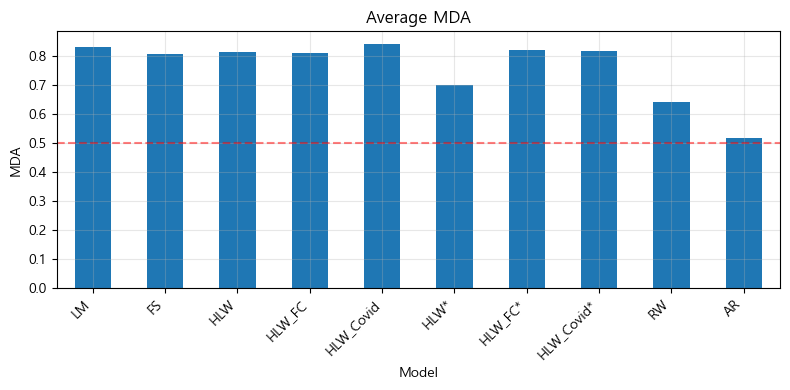

In [18]:
res.plot_mda_results(fig_size=(8, 4), base='act', segments=segments)

In [19]:
# 2020년1분기 - 2024년 3분기
segments = {'covid': (spec.targets[16], spec.targets[-1])}
mda_res, mda_avg = res.get_mda_seg(base='act', verbose=False, segments=segments)
print_mda(mda_res, mda_avg, layout='top_bottom')

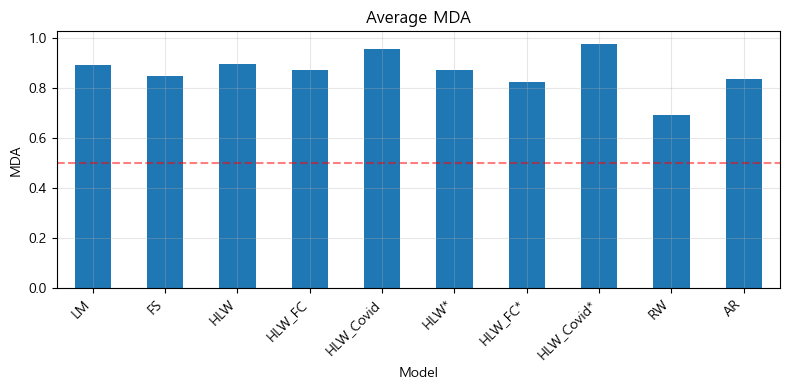

In [20]:
res.plot_mda_results(fig_size=(8, 4), base='act', segments=segments)

In [21]:
# 2016년 1분기 - 2019년 4분기
segments = {'ex_covid': (spec.targets[0], spec.targets[15])}
mda_res, mda_avg = res.get_mda_seg(base='act', verbose=False, segments=segments)
print_mda(mda_res, mda_avg, layout='top_bottom')

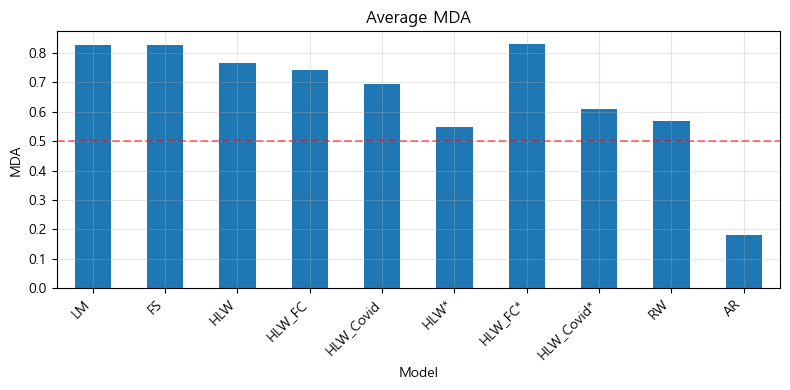

In [22]:
res.plot_mda_results(fig_size=(8, 4), base='act', segments=segments)

#### **II-2. 실질GDP 예측: 누적 실질GDP성장률의 연율**

- **데이터셋 설정**

In [23]:
df = df_all.copy()
var_list = ['rgdp', 'infe', 'inf1']
#df['rgdp'] = df['rgdp'].pct_change(4) * 100
df['inf1'] = df['inf1'].pct_change(4) * 100
data = df[var_list].dropna()
data_gdp = data.copy()
data_gdp

,rgdp,infe,inf1
Date,,,
2002-03-31,274419.9,4.35,2.99
2002-06-30,279643.7,4.30,2.96
2002-09-30,284837.5,3.90,2.88
2002-12-31,287527.5,4.10,3.03
2003-03-31,285982.5,4.47,3.19
...,...,...,...
2023-09-30,563035.7,3.30,3.74
2023-12-31,565597.6,3.33,3.29
2024-03-31,572951.0,3.07,2.57


In [24]:
# 예측 설정, Spec 객체 생성
spec = Spec(horizon=[3, 12, 24], 
            targets=pd.date_range(start='2016-03-31', end='2024-09-30', freq='Q'), 
            model_list=['LM', 'FS', 'HLW', 'HLW_FC', 'HLW_Covid', 
                        'HLW_smoothed', 'HLW_FC_smoothed', 'HLW_Covid_smoothed',
                        'RW', 'AR'],
            #model_list=['HLW_smoothed'],
            lag=1, 
            rolling=10)

# spec에 paths 추가
spec.paths = paths

In [25]:
valid = NIRValidation(spec)
res = valid.nir_wfvalid_for_annualized(data_gdp, target_var='gdp', type='regression')

========Validation Options========
Horizon: (3, 12, 24)-months ahead
Targets Range: 2016-03-31 to 2024-09-30
Model List: ['LM', 'FS', 'HLW', 'HLW_FC', 'HLW_Covid', 'HLW_smoothed', 'HLW_FC_smoothed', 'HLW_Covid_smoothed', 'RW', 'AR']
Lag: 1
Rolling: 10-years
Target Variable: rgdp
Validation type: Forecasting gdp based on regression model


Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

Processing targets:   0%|          | 0/35 [00:00<?, ?it/s]

### **RMSE, MAE**

In [26]:
rmse_mae_res, rmse_mae_avg = res.get_rmse_mae()
print_rmse_mae(rmse_mae_res, rmse_mae_avg, layout='top_bottom')

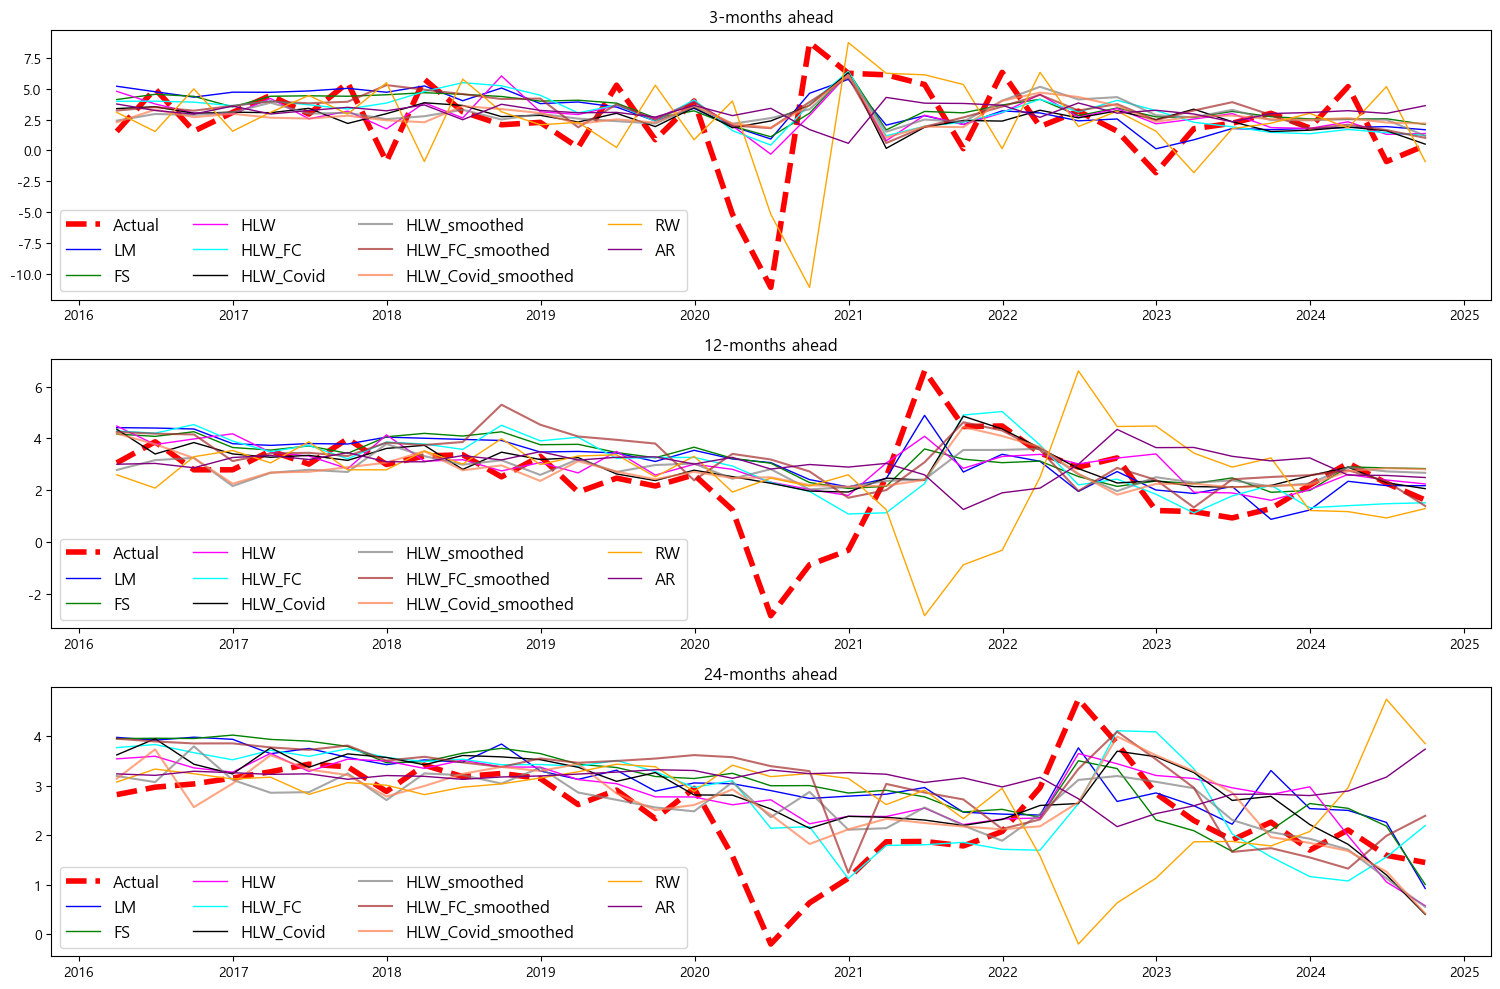

In [27]:
# 예측결과 그림
# Find the model with the smallest RMSE value
min_rmse_model = rmse_mae_avg.data.loc[:, 'RMSE'].idxmin()

# Update alpha values
alpha = {model: 1 if model == min_rmse_model else 0.7 for model in model_list}
line_width = {model: 3 if model == min_rmse_model else 1.5 for model in model_list}
res.plot_pred_results(fig_size=(15, 10), alpha=alpha, line_width=line_width, loc='lower left', n_col=4)

### **MDA**

In [28]:
# 2016년1분기 - 2024년 3분기
segments = {'full': (spec.targets[0], spec.targets[-1])}

mda_res, mda_avg = res.get_mda_seg(base='act', verbose=False, segments=segments)
print_mda(mda_res, mda_avg, layout='top_bottom')

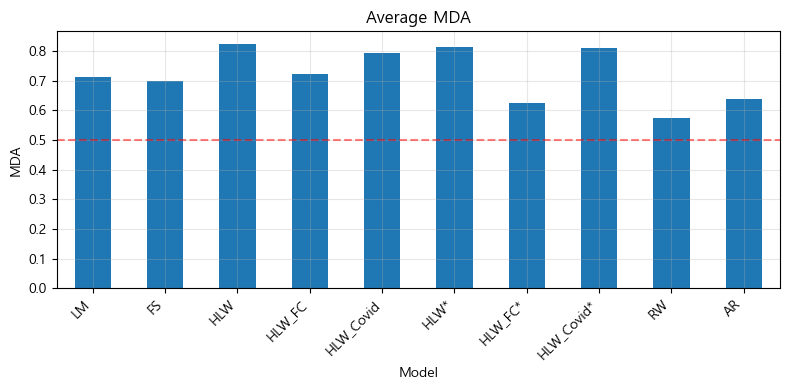

In [29]:
res.plot_mda_results(fig_size=(8, 4), base='act', segments=segments)

In [30]:
# 2020년1분기 - 2024년 3분기
segments = {'covid': (spec.targets[16], spec.targets[-1])}

mda_res, mda_avg = res.get_mda_seg(base='act', verbose=False, segments=segments)
print_mda(mda_res, mda_avg, layout='top_bottom')

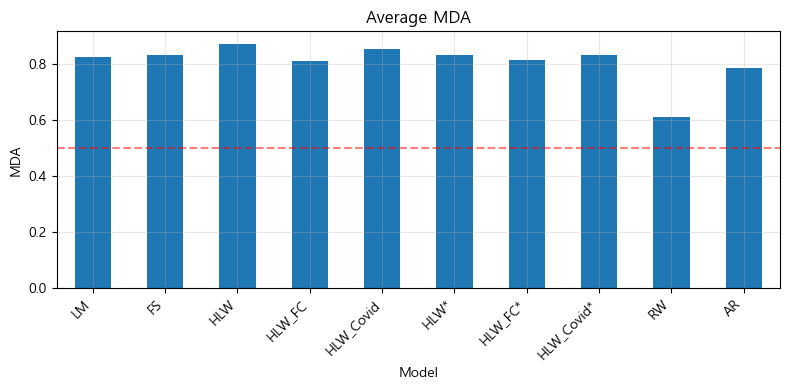

In [31]:
res.plot_mda_results(fig_size=(8, 4), base='act', segments=segments)

In [32]:
# 2016년1분기 - 2019년 4분기
segments = {'ex_covid': (spec.targets[0], spec.targets[15])}

mda_res, mda_avg = res.get_mda_seg(base='act', verbose=False, segments=segments)
print_mda(mda_res, mda_avg, layout='top_bottom')

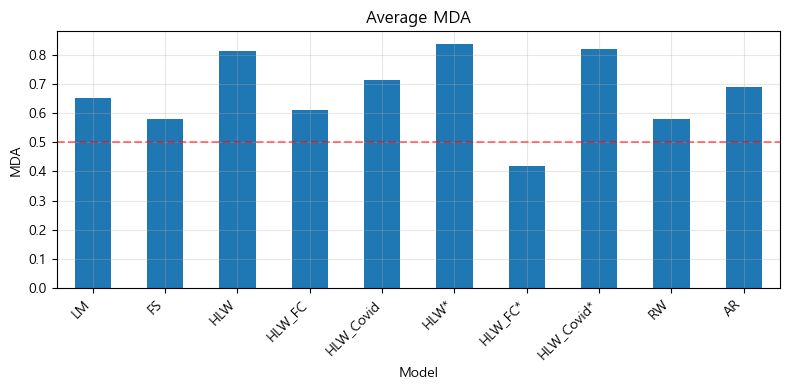

In [33]:
res.plot_mda_results(fig_size=(8, 4), base='act', segments=segments)

### IRF((실질금리-실질중립금리), 근원인플레이션, 실질GDP성장률)

#### 데이터 전처리

In [34]:
df_all['rgdpg'] = df_all['rgdp'].pct_change(4) * 100
df_all['inf1g'] = df_all['inf1'].pct_change(4) * 100
df_all['realrate'] = df_all['interest'] - df_all['inf1g']
df_irf = pd.concat([df_all, rstar], axis=1)

In [35]:
irf_list = ['realrate', 'inf1g', 'rgdpg', 'LM', 'FS', 'HLW', 'HLW_FC', 'HLW_Covid', 'HLW_smoothed', 'HLW_FC_smoothed', 'HLW_Covid_smoothed']
df_irf = df_irf[irf_list].dropna()

for model in ['LM', 'FS', 'HLW', 'HLW_FC', 'HLW_Covid', 'HLW_smoothed', 'HLW_FC_smoothed', 'HLW_Covid_smoothed']:
    df_irf[model + '_gap'] = df_irf['realrate'] - df_irf[model]
    
df_irf = df_irf[['inf1g', 'rgdpg',
                 'LM_gap', 'FS_gap', 'HLW_gap', 'HLW_FC_gap',
                 'HLW_Covid_gap', 'HLW_smoothed_gap',
                 'HLW_FC_smoothed_gap', 'HLW_Covid_smoothed_gap']]
df_irf

,inf1g,rgdpg,LM_gap,FS_gap,HLW_gap,HLW_FC_gap,HLW_Covid_gap,HLW_smoothed_gap,HLW_FC_smoothed_gap,HLW_Covid_smoothed_gap
2004-12-31,3.10,3.37,-0.30,-0.58,-1.78,-3.00,-1.93,-1.46,-2.89,-1.96
2005-03-31,3.13,2.87,-0.46,-0.68,-1.89,-3.11,-2.05,-1.58,-2.97,-2.08
2005-06-30,2.54,3.94,0.03,-0.04,-1.26,-2.48,-1.41,-0.89,-2.32,-1.44
2005-09-30,1.92,5.13,0.65,0.58,-0.63,-1.89,-0.78,-0.14,-1.76,-0.81
2005-12-31,1.82,5.47,0.83,0.93,-0.21,-1.48,-0.36,0.40,-1.41,-0.43
...,...,...,...,...,...,...,...,...,...,...
2023-09-30,3.74,1.29,-1.13,0.41,0.87,1.03,1.51,-0.63,1.09,0.68
2023-12-31,3.29,2.22,-0.68,0.90,1.36,1.33,1.98,-0.18,1.44,1.19
2024-03-31,2.57,3.09,0.09,1.56,2.03,1.83,2.66,0.50,1.97,1.86
2024-06-30,2.09,2.29,0.73,2.03,2.55,2.26,3.17,1.02,2.41,2.38


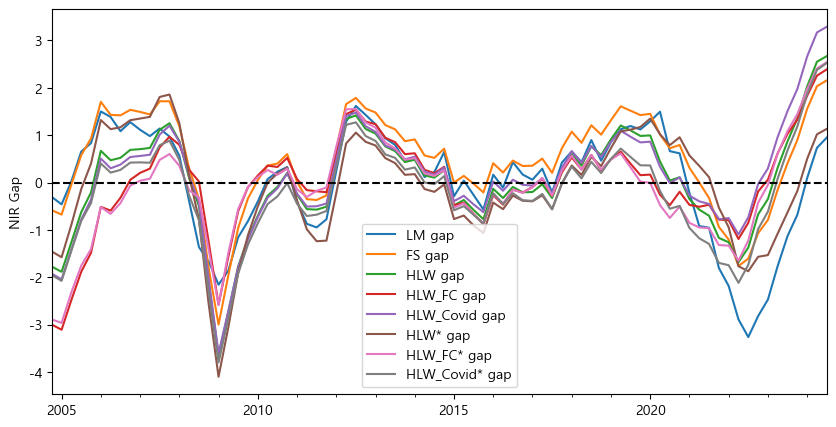

In [36]:
df_gap = df_irf.filter(regex='_gap$')
df_gap_renamed = df_gap.rename(columns=lambda x: x.replace('_inf_smoothed', '*').replace('_smoothed', '*').replace('_gap', ' gap'))
ax = df_gap_renamed.plot(figsize=(10, 5))
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('NIR Gap')
fig = plt.gcf()
fig.savefig('fig/nir_gaps.png', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
df_irf_std = (df_irf - df_irf.mean()) / df_irf.std()

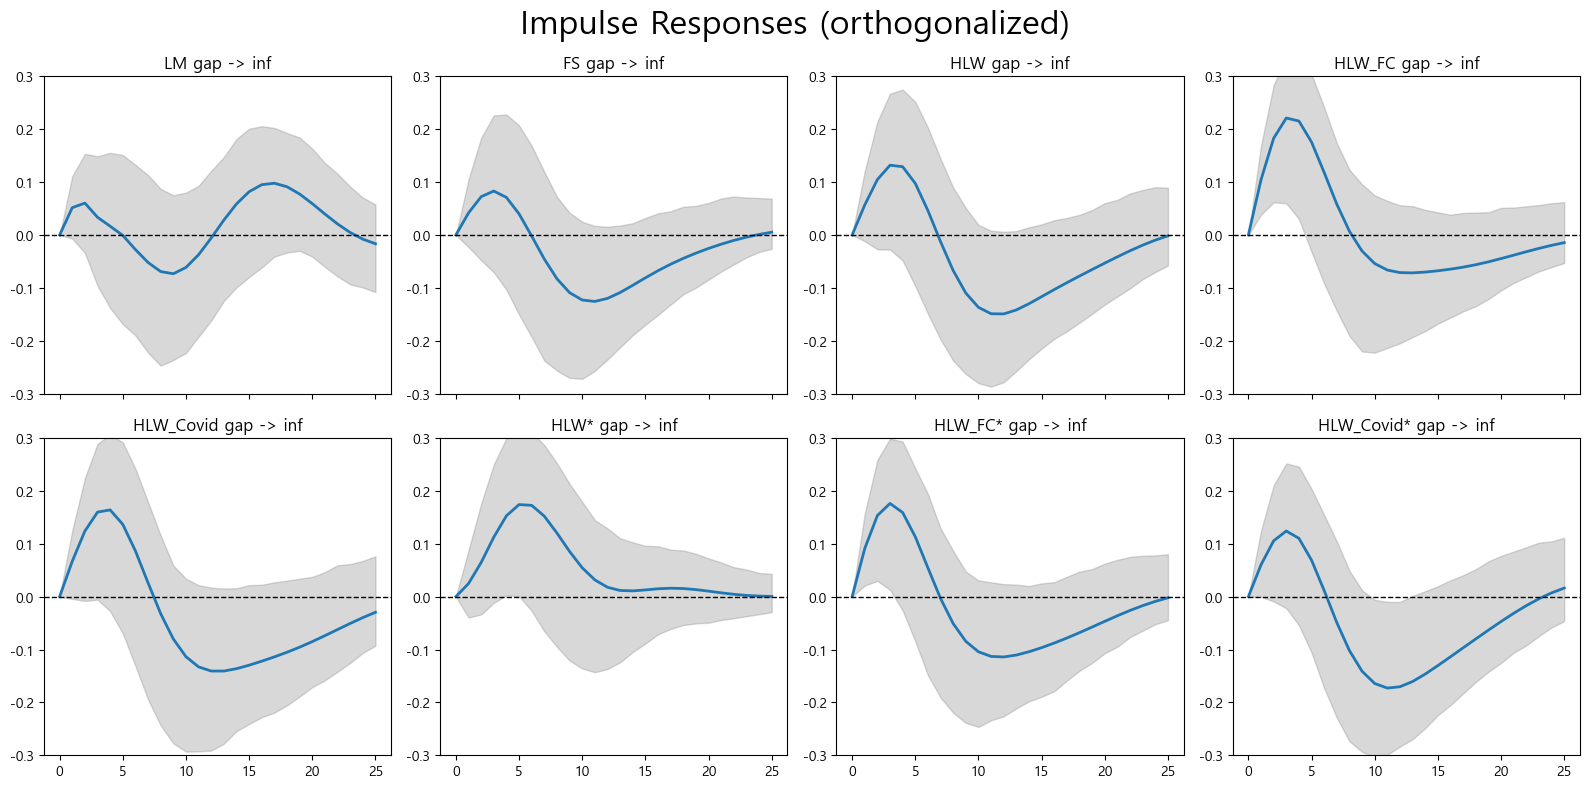

In [38]:
gap_cols = [col for col in df_irf_std.columns if col.endswith('_gap')]

fig, axs = plt.subplots(2, 4, figsize=(16, 8), sharex=True)
axs = axs.flatten()

for j, gap_col in enumerate(gap_cols):
    # prepare data and fit VAR
    var_data = df_irf_std[['inf1g', 'rgdpg', gap_col]].dropna()
    model = sm.tsa.VAR(var_data, freq='Q')
    res = model.fit(maxlags=4, ic='bic', trend='c')
    irf_result = res.irf(25)
    
    # Get impulse response for 'inf1g' (index 0) to gap_col (index 2)
    irf_vals = irf_result.orth_irfs[:, 0, 2]
    # obtain confidence intervals via Monte Carlo error bands 
    ci_lower, ci_upper = irf_result.errband_mc(orth=True)
    
    ax = axs[j]
    ax.fill_between(range(len(irf_vals)), ci_lower[:, 0, 2], ci_upper[:, 0, 2], color='grey', alpha=0.3)
    ax.plot(range(len(irf_vals)), irf_vals, lw=2)
    
    ax.set_xticks(range(0, 26, 5))
    ax.set_xticklabels(range(0, 26, 5))
    ax.axhline(0, color='black', lw=1, ls='--')
    ax.set_ylim(-0.3, 0.3)
    title_str = gap_col.replace("_inf_smoothed", "*").replace("_smoothed", "*").replace("_gap", " gap")
    ax.set_title(f"{title_str} -> inf")

fig.suptitle("Impulse Responses (orthogonalized)", fontsize=24)
plt.tight_layout()
plt.show()
fig.savefig('fig/irf_inflation.png', dpi=300, bbox_inches='tight')

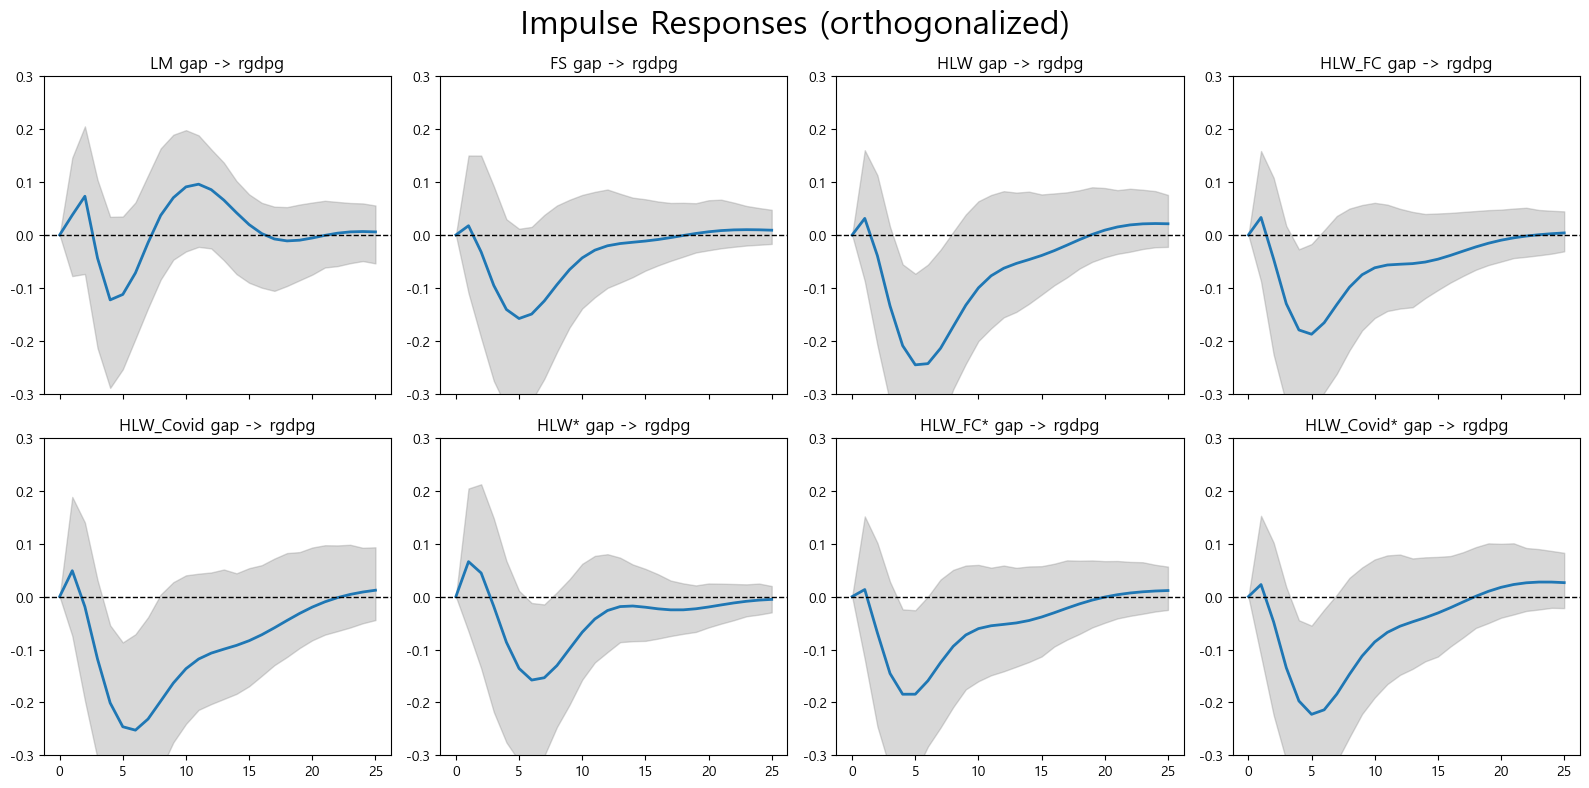

In [39]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8), sharex=True)
axs = axs.flatten()

for j, gap_col in enumerate(gap_cols):
    # prepare data and fit VAR
    var_data = df_irf_std[['inf1g', 'rgdpg', gap_col]].dropna()
    model = sm.tsa.VAR(var_data, freq='Q')
    res = model.fit(maxlags=4, ic='bic', trend='c')
    irf_result = res.irf(25)
    
    # Use index 1 for response variable "rgdpg"
    irf_vals = irf_result.orth_irfs[:, 1, 2]
    # obtain confidence intervals via Monte Carlo error bands 
    ci_lower, ci_upper = irf_result.errband_mc(orth=True)
    
    ax = axs[j]
    ax.fill_between(range(len(irf_vals)), ci_lower[:, 1, 2], ci_upper[:, 1, 2], color='grey', alpha=0.3)
    ax.plot(range(len(irf_vals)), irf_vals, lw=2)
    
    ax.set_xticks(range(0, 26, 5))
    ax.set_xticklabels(range(0, 26, 5))
    ax.axhline(0, color='black', lw=1, ls='--')
    ax.set_ylim(-0.3, 0.3)
    title_str = gap_col.replace("_inf_smoothed", "*").replace("_smoothed", "*").replace("_gap", " gap")
    ax.set_title(f"{title_str} -> rgdpg")

fig.suptitle("Impulse Responses (orthogonalized)", fontsize=24)
plt.tight_layout()
plt.show()
fig.savefig('fig/irf_gdp.png', dpi=300, bbox_inches='tight')


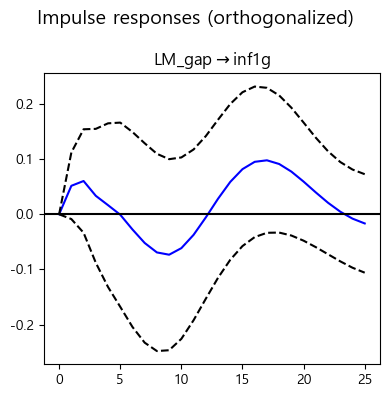

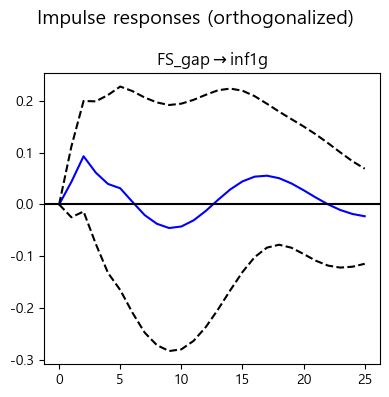

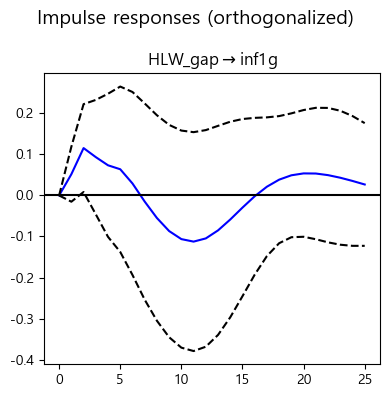

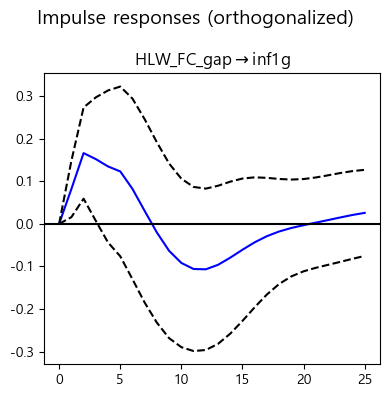

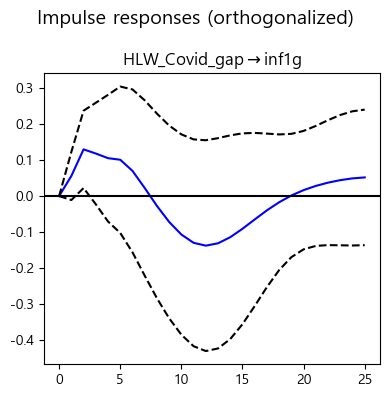

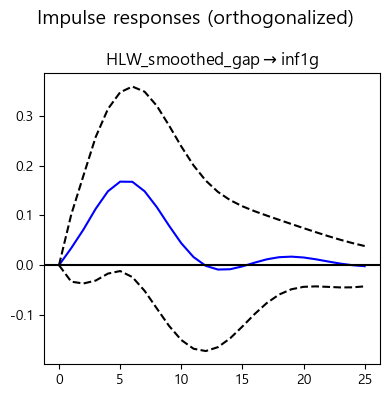

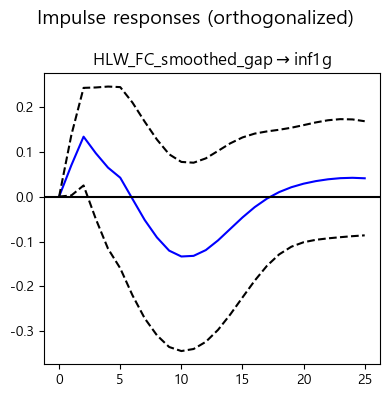

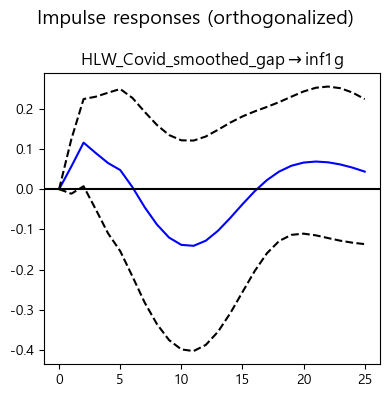

In [41]:
gap_cols = [col for col in df_irf_std.columns if col.endswith('_gap')]

for i, gap_col in enumerate(gap_cols):
    var_data = df_irf_std[['inf1g', 'rgdpg', gap_col]].dropna()
    model = sm.tsa.VAR(var_data, freq='Q')
    res = model.fit(maxlags=4, ic='aic', trend='c')
    irf = res.irf(25)
    
    fig_irf = irf.plot(orth=True, impulse=gap_col, response='inf1g', figsize=(4, 4))
        
    for ax in fig_irf.axes:
        ax.set_xticks(range(0, 26, 5))
        ax.set_xticklabels(range(0, 26, 5))
    plt.tight_layout()
    plt.show()
    
    # 누적 IRF with reduced figure size
    #fig_cirf = irf.plot_cum_effects(orth=True, impulse=gap_col, figsize=(4, 9))
    #for ax in fig_cirf.axes:
    #    ax.set_xticks(range(0, 26, 5))
    #    ax.set_xticklabels(range(0, 26, 5))
    #plt.tight_layout()
    #plt.show()

In [42]:
from bok_da.ts.var import VectorAutoRegression as VAR
from bok_da.ts.var import var_irf_bootstrap, order_var

In [43]:
p = order_var(var_data, lag_max=4)
model = VAR(lag=p.bic)
res = model.fit(var_data, irf='short', h=25) # by default: h=16, q=90, n=2000

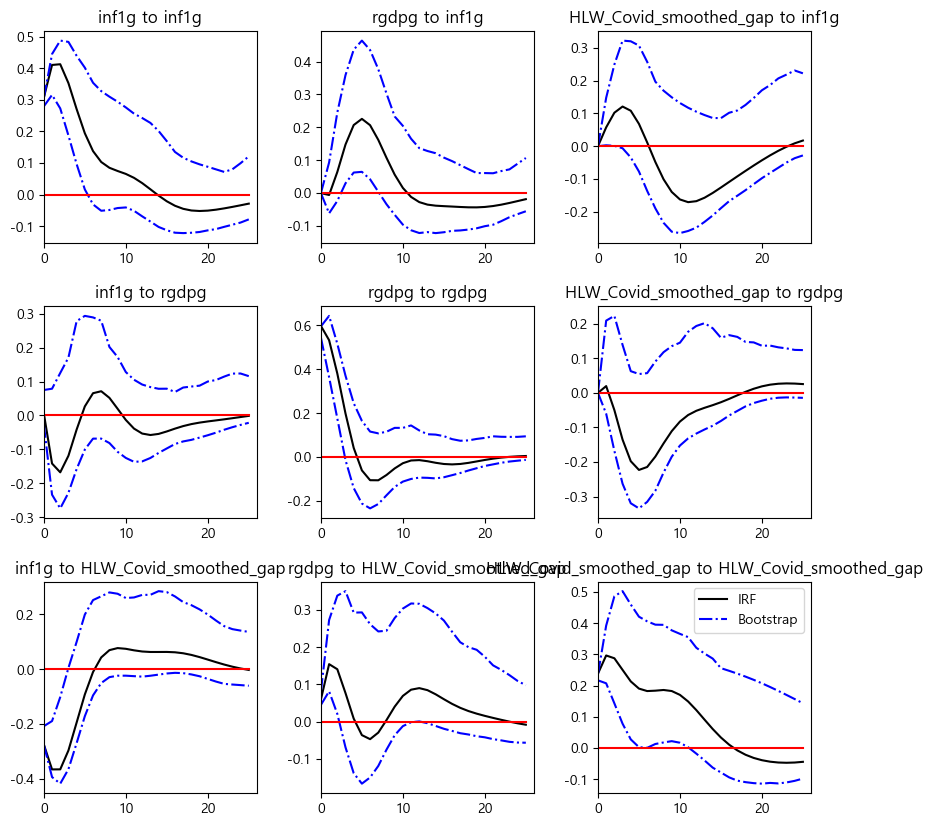

In [44]:
res.plot_irf(title=False)